# Quantum Molecular Unfolding
https://arxiv.org/abs/2107.13607

Kevin Mato, Riccardo Mengoni, Daniele Ottaviani, Gianluca Palermo

*Abstract*: Molecular Docking (MD) is an important step of the drug discovery process which aims at calculating the preferred position and shape of one molecule to a second when they are bound to each other. During such analysis, 3D representations of molecules are manipulated according to their degree of freedoms: rigid roto-translation and fragment rotations along the rotatable bonds. In our work, we focused on one specific phase of the molecular docking procedure i.e. Molecular Unfolding (MU), which is used to remove the initial bias of a molecule by expanding it to an unfolded shape. The objective of the MU problem is to find the configuration that maximizes the molecular area, or equivalently, that maximizes the internal distances between atoms inside the molecule. We propose a quantum annealing approach to MU by formulating it as a High-order Unconstrained Binary Optimization (HUBO) which was possible to solve on the latest D-Wave annealing hardware (2000Q and Advantage). Results and performances obtained with quantum annealers are compared with state of art classical solvers.


In [ ]:
!pip install dimod
!pip install dwave-neal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('../')
import math
import sympy
from sympy import poly
import numpy
import dimod
from sympy import symbols
from copy import deepcopy
import neal

HUBOs for Quantum Molecular unfolding problem have this form $H(x_{ik})=A\sum_{i} \left( \sum_{k=1}^d x_{ik} -1 \right)^2 - \sum_{\substack{a,b}} D_{ab}( {\Theta})^2$

where $H_A=A\sum_{i} \left( \sum_{k=1}^d x_{ik} -1 \right)^2$ is the hard constraint, modulated by coefficient A which has to be large wrt maximum coefficint appearing in $H_B=\sum_{\substack{a,b}} D_{ab}( {\Theta})^2$ which is the optimization term, responsible for maximization of internal distances.


HUBOs are already generated and are stored in folders. HUBOs are divided in several groups, depending on number of rotatable bonds considered (e.g. 5 rotatable bonds in the folder *./N_Rot_5*) and value of the threshold used to generate the HUBO (e.g. threshold value equal to 100 in folder *./HUBO_5_100*).

### Select the Molecular HUBO you want to study.
Check that the path is correct.

In [ ]:
HUBO_Mol="/content/drive/MyDrive/MolecularDockingData/N_Rot_2/HUBO_40A12Rot_2#s2"

Initializing the variables need in the problem

In [ ]:
#numer of rotatable bond considered
num_rots=int(HUBO_Mol[HUBO_Mol.find("s")+1])

#Initialize variables
if num_rots==2:
    a0, a1, a2, a3  = symbols('a0, a1, a2, a3')
if num_rots==4:
    a0, a1, a2, a3, a4, a5, a6, a7  = symbols('a0, a1, a2, a3, a4, a5, a6, a7')
if num_rots==5:
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9  = symbols('a0, a1, a2, a3, a4, a5, a6, a7, a8, a9')
if num_rots==6:
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11  = symbols('a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11')
if num_rots==8:
    a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15  = symbols('a0, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11, a12, a13, a14, a15')

Read the correct files in folder.
Files named  *_total*  contain the scoring function $H_B$ to evaluate (in the format of a *sympy polynomial*).

In [ ]:
FILE= HUBO_Mol + ".txt"
total_FILE= HUBO_Mol + '_total.txt'

read_total = open(total_FILE, 'r').read()
total=eval(read_total)

Check the max coefficient appearing in $H_B$ and set the hard constraint strenght $A$ as 10 times this number

In [ ]:
#This is used to check the maximum coefficient appearing in Hubo_B
A_const=0
read_dictionary_B = open(FILE, 'r').read()
HUBO_B=eval(read_dictionary_B)

#We set the Hard constraint strength as the (maximum coefficient appearing in Hubo_B)*const.
#const was empirically selected to be 10
const=10
A_const=max(map(abs, list(HUBO_B.values())))*const

#read the final HUBO
read_dictionary= open(FILE, 'r').read()
HUBO=eval(read_dictionary)

Current size of the HUBO

In [ ]:
print("Current size of the HUBO:",len(HUBO))

Current size of the HUBO: 137


Define the Threshold approximation function.
Coefficints with absolute value less than $10^{val}$ are deleted from the HUBO.

In [ ]:
def threshold_approx(h, val=1):
    d =h.copy()
    monoms = h.keys()
    for m in monoms:
        temp = d[m]
        if (temp < 0.0):
            temp = -1.0 * temp
        if (temp <= (10.0 ** (val))):
            del d[m]
    return d

### Select a threshold value and apply the threshold approximation

In [ ]:
#Coefficints with absolute value less than 10^{threshold} are deleted from the HUBO.
threshold=2

HUBO=threshold_approx(HUBO,threshold)

print("Size of the HUBO after threshold approximation:",len(HUBO))

Size of the HUBO after threshold approximation: 73


Constract the binary quadratic model (QUBO) from the HUBO using the function *dimod.make_quadratic* , which takes in input a *strength* parameter set to 1.5*(maximum HUBO value) for empirical reasons (as suggested by D-Wave researchers)

In [ ]:
#calculate the strength parameter needed by make_quadratic
max_hubo_value=max(map(abs, list(HUBO.values())))
strength=1.5*max_hubo_value
#generate the bqm
bqm = dimod.make_quadratic(HUBO, strength, dimod.BINARY)

### Select a sampler and the sample_size
Here we consider the Simulated annealing solver. In order to use the Quantum annealing solver, please set up a D-Wave Leap account as explained here  https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html

Inthat case use DWaveSampler() with annealing schedule of $1 \mu second$

*sampler = EmbeddingComposite(DWaveSampler())*

*sampleset = sampler.sample(bqm, num_reads=sample_size, anneal_schedule=[[0.0,0.0],[1.0,1.0]])*

Remember that HUBOs get harder to solve when more rotatable bonds are considerd.
Increase the sample_size accordingly (suggested sample_sizes: 1000, 10000, 100000)


In [ ]:
sampler = neal.SimulatedAnnealingSampler()

sample_size=10

Run the problem and display sample

In [ ]:
sampleset = sampler.sample(bqm, num_reads=sample_size)
print(sampleset)

   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16       energy num_oc.
4  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0 -4662.453125       1
1  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0 -4649.703125       1
3  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 -4648.699219       1
8  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0 -4630.828125       1
6  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0 -4630.729492       1
0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0 -4626.213867       1
9  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0  0 -4626.213867       1
5  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  -4623.90625       1
2  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0 -4595.294922       1
7  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0 -4528.942383       1
['BINARY', 10 rows, 10 samples, 16 variables]


### PostProcessing Part
Evaluating the sampleset on  $H_B$


In [ ]:
new_answer=sampleset.record.sample

counter=0
solutions={}
occur_solutions=[]
occurrences={}

for s in range(len(new_answer)):
    bit_new_answer=new_answer[s]

    if num_rots==2:

        k1=tuple(i for i,x in enumerate(bit_new_answer[0:8]) if x == 1)
        k2=tuple(i for i,x in enumerate(bit_new_answer[8:16]) if x == 1)

        if len(k1)==1:
            if len(k2)==1:

                occur_solutions.append((k1[0]+1, k2[0]+1))

                c1=numpy.cos((numpy.pi/4.0)*(k1[0]+1))
                s1=numpy.sin((numpy.pi/4.0)*(k1[0]+1))
                c2=numpy.cos((numpy.pi/4.0)*(k2[0]+1))
                s2=numpy.sin((numpy.pi/4.0)*(k2[0]+1))

                minim=total(c1,s1,c2,s2)

                solutions[(k1[0]+1, k2[0]+1)]= minim
                counter=counter+1

    if num_rots==4:

        k1=tuple(i for i,x in enumerate(bit_new_answer[0:8]) if x == 1)
        k2=tuple(i for i,x in enumerate(bit_new_answer[8:16]) if x == 1)
        k3=tuple(i for i,x in enumerate(bit_new_answer[16:24]) if x == 1)
        k4=tuple(i for i,x in enumerate(bit_new_answer[24:32]) if x == 1)


        if len(k1)==1:
            if len(k2)==1:
                if len(k3)==1:
                    if len(k4)==1:

                        occur_solutions.append((k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1))

                        c1=numpy.cos((numpy.pi/4.0)*(k1[0]+1))
                        s1=numpy.sin((numpy.pi/4.0)*(k1[0]+1))
                        c2=numpy.cos((numpy.pi/4.0)*(k2[0]+1))
                        s2=numpy.sin((numpy.pi/4.0)*(k2[0]+1))
                        c3=numpy.cos((numpy.pi/4.0)*(k3[0]+1))
                        s3=numpy.sin((numpy.pi/4.0)*(k3[0]+1))
                        c4=numpy.cos((numpy.pi/4.0)*(k4[0]+1))
                        s4=numpy.sin((numpy.pi/4.0)*(k4[0]+1))

                        minim=total(c1,s1,c2,s2,c3,s3,c4,s4)

                        solutions[(k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1)]= minim
                        counter=counter+1

    if num_rots==5:

        k1=tuple(i for i,x in enumerate(bit_new_answer[0:8]) if x == 1)
        k2=tuple(i for i,x in enumerate(bit_new_answer[8:16]) if x == 1)
        k3=tuple(i for i,x in enumerate(bit_new_answer[16:24]) if x == 1)
        k4=tuple(i for i,x in enumerate(bit_new_answer[24:32]) if x == 1)
        k5=tuple(i for i,x in enumerate(bit_new_answer[32:40]) if x == 1)


        if len(k1)==1:
            if len(k2)==1:
                if len(k3)==1:
                    if len(k4)==1:
                        if len(k5)==1:

                            occur_solutions.append((k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1))

                            c1=numpy.cos((numpy.pi/4.0)*(k1[0]+1))
                            s1=numpy.sin((numpy.pi/4.0)*(k1[0]+1))
                            c2=numpy.cos((numpy.pi/4.0)*(k2[0]+1))
                            s2=numpy.sin((numpy.pi/4.0)*(k2[0]+1))
                            c3=numpy.cos((numpy.pi/4.0)*(k3[0]+1))
                            s3=numpy.sin((numpy.pi/4.0)*(k3[0]+1))
                            c4=numpy.cos((numpy.pi/4.0)*(k4[0]+1))
                            s4=numpy.sin((numpy.pi/4.0)*(k4[0]+1))
                            c5=numpy.cos((numpy.pi/4.0)*(k5[0]+1))
                            s5=numpy.sin((numpy.pi/4.0)*(k5[0]+1))

                            minim=total(c1,s1,c2,s2,c3,s3,c4,s4,c5,s5)

                            solutions[(k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1)]= minim
                            counter=counter+1

    if num_rots==6:

        k1=tuple(i for i,x in enumerate(bit_new_answer[0:8]) if x == 1)
        k2=tuple(i for i,x in enumerate(bit_new_answer[8:16]) if x == 1)
        k3=tuple(i for i,x in enumerate(bit_new_answer[16:24]) if x == 1)
        k4=tuple(i for i,x in enumerate(bit_new_answer[24:32]) if x == 1)
        k5=tuple(i for i,x in enumerate(bit_new_answer[32:40]) if x == 1)
        k6=tuple(i for i,x in enumerate(bit_new_answer[40:48]) if x == 1)


        if len(k1)==1:
            if len(k2)==1:
                if len(k3)==1:
                    if len(k4)==1:
                        if len(k5)==1:
                            if len(k6)==1:

                                occur_solutions.append((k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1, k6[0]+1))

                                c1=numpy.cos((numpy.pi/4.0)*(k1[0]+1))
                                s1=numpy.sin((numpy.pi/4.0)*(k1[0]+1))
                                c2=numpy.cos((numpy.pi/4.0)*(k2[0]+1))
                                s2=numpy.sin((numpy.pi/4.0)*(k2[0]+1))
                                c3=numpy.cos((numpy.pi/4.0)*(k3[0]+1))
                                s3=numpy.sin((numpy.pi/4.0)*(k3[0]+1))
                                c4=numpy.cos((numpy.pi/4.0)*(k4[0]+1))
                                s4=numpy.sin((numpy.pi/4.0)*(k4[0]+1))
                                c5=numpy.cos((numpy.pi/4.0)*(k5[0]+1))
                                s5=numpy.sin((numpy.pi/4.0)*(k5[0]+1))
                                c6=numpy.cos((numpy.pi/4.0)*(k6[0]+1))
                                s6=numpy.sin((numpy.pi/4.0)*(k6[0]+1))

                                minim=total(c1,s1,c2,s2,c3,s3,c4,s4,c5,s5,c6,s6)

                                solutions[(k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1, k6[0]+1)]= minim
                                counter=counter+1

    if num_rots==8:

        k1=tuple(i for i,x in enumerate(bit_new_answer[0:8]) if x == 1)
        k2=tuple(i for i,x in enumerate(bit_new_answer[8:16]) if x == 1)
        k3=tuple(i for i,x in enumerate(bit_new_answer[16:24]) if x == 1)
        k4=tuple(i for i,x in enumerate(bit_new_answer[24:32]) if x == 1)
        k5=tuple(i for i,x in enumerate(bit_new_answer[32:40]) if x == 1)
        k6=tuple(i for i,x in enumerate(bit_new_answer[40:48]) if x == 1)
        k7=tuple(i for i,x in enumerate(bit_new_answer[48:56]) if x == 1)
        k8=tuple(i for i,x in enumerate(bit_new_answer[56:64]) if x == 1)



        if len(k1)==1:
            if len(k2)==1:
                if len(k3)==1:
                    if len(k4)==1:
                        if len(k5)==1:
                            if len(k6)==1:
                                if len(k7)==1:
                                    if len(k8)==1:

                                        occur_solutions.append((k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1, k6[0]+1, k7[0]+1, k8[0]+1))

                                        c1=numpy.cos((numpy.pi/4.0)*(k1[0]+1))
                                        s1=numpy.sin((numpy.pi/4.0)*(k1[0]+1))
                                        c2=numpy.cos((numpy.pi/4.0)*(k2[0]+1))
                                        s2=numpy.sin((numpy.pi/4.0)*(k2[0]+1))
                                        c3=numpy.cos((numpy.pi/4.0)*(k3[0]+1))
                                        s3=numpy.sin((numpy.pi/4.0)*(k3[0]+1))
                                        c4=numpy.cos((numpy.pi/4.0)*(k4[0]+1))
                                        s4=numpy.sin((numpy.pi/4.0)*(k4[0]+1))
                                        c5=numpy.cos((numpy.pi/4.0)*(k5[0]+1))
                                        s5=numpy.sin((numpy.pi/4.0)*(k5[0]+1))
                                        c6=numpy.cos((numpy.pi/4.0)*(k6[0]+1))
                                        s6=numpy.sin((numpy.pi/4.0)*(k6[0]+1))
                                        c7=numpy.cos((numpy.pi/4.0)*(k7[0]+1))
                                        s7=numpy.sin((numpy.pi/4.0)*(k7[0]+1))
                                        c8=numpy.cos((numpy.pi/4.0)*(k8[0]+1))
                                        s8=numpy.sin((numpy.pi/4.0)*(k8[0]+1))

                                        minim=total(c1,s1,c2,s2,c3,s3,c4,s4,c5,s5,c6,s6,c7,s7,c8,s8)

                                        solutions[(k1[0]+1, k2[0]+1, k3[0]+1, k4[0]+1, k5[0]+1, k6[0]+1, k7[0]+1, k8[0]+1)]= minim

                                        counter=counter+1


for sols in  list(set(occur_solutions)):
    occurrences[sols]=occur_solutions.count(sols)

Final_Solutions= sorted(solutions.items(), key=lambda x: x[1], reverse=True)

## Display Solutions

Number of acceptable solutions that do not violate the hard contraint:

In [ ]:
print( "Number of acceptable solutions found: ", counter)

Number of acceptable solutions found:  10


Dictionary containing all the acceptable solutions found. Each solution is of the following form
$[(k_1..k_d), H_B(k_1..k_d)]$ where $(k_1..k_d)$ are the parameters that define the torsional angle value $\theta_i=\frac{\pi}{4}k_i$, while $H_B(k_1..k_d)$ is the value of the optimization function, evaluated in $(k_1..k_d)$

In [ ]:
print("All solutions found: ", Final_Solutions)

All solutions found:  [((2, 4), 327.366871524616), ((5, 5), 319.223768838180), ((1, 5), 307.453415431885), ((2, 3), 307.388788344650), ((5, 6), 306.078122119703), ((8, 4), 304.424975855339), ((8, 5), 298.720230095581), ((6, 3), 247.298528115165), ((6, 1), 182.024160945539)]


Occurrences of each solution $(k_1..k_d)$

In [ ]:
print( "Occurrences of each solution: ", occurrences)

Occurrences of each solution:  {(2, 4): 1, (5, 5): 1, (8, 4): 2, (1, 5): 1, (6, 1): 1, (2, 3): 1, (5, 6): 1, (6, 3): 1, (8, 5): 1}


Best solution found  $(k_1..k_d)_{best}$ and its occurrency

In [ ]:
print( "Best Solution Found: ", Final_Solutions[0])
print( "Best Solution Occurences: ", occurrences[Final_Solutions[0][0]])

Best Solution Found:  ((2, 4), 327.366871524616)
Best Solution Occurences:  1


In [ ]:
import numpy as np
import random

def rotation_matrix(theta):
    """
    Compute a 2D rotation matrix for a given angle theta.
    For higher dimensions, extend this function as needed.
    """
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def compute_distance_squared(atom1, atom2):
    """
    Compute the squared Euclidean distance between two points.
    """
    return np.sum((atom1 - atom2)**2)

def extract_from_hubo(hubo, num_discrete_angles=8):
    """
    Extract atom coordinates, torsional bonds, and an example x vector from HUBO data.

    Parameters:
        hubo (dict): The HUBO dictionary with tuples as keys representing variables and coefficients as values.
        num_discrete_angles (int): Number of discrete angles for each torsional bond.

    Returns:
        atom_coords (list of numpy arrays): Dummy atom coordinates.
        torsional_bonds (list of tuples): Pairs of indices representing torsional bonds.
        x_example (list): Example one-hot encoded vector for the torsional angles.
    """
    # Extract unique indices from HUBO keys
    all_indices = set()
    for key in hubo.keys():
        if isinstance(key, tuple):
            all_indices.update(key)
        elif isinstance(key, int):  # Single variable
            all_indices.add(key)

    max_index = max(all_indices)  # Maximum variable index

    # Generate dummy atom coordinates (2D representation)
    atom_coords = [np.array([i, 0.0]) for i in range(max_index + 1)]

    # Generate torsional bonds as pairs of consecutive indices
    torsional_bonds = [(i, i + 1) for i in range(max_index)]

    # Construct x_example: One-hot encoding for each torsional bond
    x_example = []
    for _ in range(len(torsional_bonds)):
        one_hot = [0] * num_discrete_angles
        one_hot[0] = 1  # Example: First angle selected
        x_example.extend(one_hot)

    return atom_coords, torsional_bonds, x_example

def molecular_unfolding_objective(hubo, x, num_discrete_angles=8, A_const=100):
    """
    Compute the molecular unfolding objective function based on HUBO data.

    Parameters:
        hubo (dict): HUBO dictionary containing variable interactions and coefficients.
        x (list of int): One-hot encoded binary variables for torsional angles.
        num_discrete_angles (int): Number of discrete angle choices per torsional bond.
        A_const (float): Weight for the hard constraint.

    Returns:
        float: The computed objective function value.
    """
    # Extract data from HUBO
    atom_coords, torsional_bonds, _ = extract_from_hubo(hubo, num_discrete_angles)

    num_bonds = len(torsional_bonds)  # Number of torsional bonds
    x_matrix = np.array(x).reshape(num_bonds, num_discrete_angles)  # Reshape binary variables

    # Hard Constraint
    hard_constraint = A_const * sum((np.sum(x_matrix[bond_idx]) - 1)**2 for bond_idx in range(num_bonds))

    # Initialize unfolded atom coordinates
    unfolded_coords = atom_coords.copy()

    # Apply rotations based on binary variables
    for bond_idx, (atom1_idx, atom2_idx) in enumerate(torsional_bonds):
        selected_angle_idx = np.argmax(x_matrix[bond_idx])  # Find selected angle index
        angle = (selected_angle_idx * 2 * np.pi) / num_discrete_angles  # Convert index to angle
        rotation = rotation_matrix(angle)

        # Apply rotation to atom2 (relative to atom1)
        relative_coords = atom_coords[atom2_idx] - atom_coords[atom1_idx]
        rotated_coords = np.dot(rotation, relative_coords) + atom_coords[atom1_idx]
        unfolded_coords[atom2_idx] = rotated_coords

    # Distance Constraint
    distance_constraint = 0
    for i, coord1 in enumerate(unfolded_coords):
        for j, coord2 in enumerate(unfolded_coords):
            if i < j:  # Avoid double counting
                distance_constraint += compute_distance_squared(coord1, coord2)

    # Return the final objective value
    return hard_constraint - distance_constraint

def random_search(hubo, num_discrete_angles=8, A_const=100, num_iterations=100):
    """
    Perform random search to find the best solution for the molecular unfolding problem.

    Parameters:
        hubo (dict): HUBO dictionary.
        num_discrete_angles (int): Number of discrete angle choices per torsional bond.
        A_const (float): Hard constraint weight.
        num_iterations (int): Number of random solutions to generate.

    Returns:
        best_solution (list): The best solution found.
        best_objective_value (float): The corresponding objective value.
    """
    best_solution = None
    best_objective_value = float('-inf')  # Assuming we're maximizing the objective value

    # Get number of bonds from HUBO
    _, torsional_bonds, _ = extract_from_hubo(hubo, num_discrete_angles)
    num_bonds = len(torsional_bonds)

    for _ in range(num_iterations):
        # Generate a random candidate solution (random one-hot encoding for each bond)
        random_solution = []
        for _ in range(num_bonds):  # For each bond
            one_hot = [0] * num_discrete_angles
            random_choice = random.randint(0, num_discrete_angles - 1)
            one_hot[random_choice] = 1
            random_solution.extend(one_hot)

        # Ensure that the solution array size matches (num_bonds * num_discrete_angles)
        if len(random_solution) != num_bonds * num_discrete_angles:
            raise ValueError(f"Random solution size does not match expected size: {num_bonds * num_discrete_angles}")

        # Evaluate the objective function for the random solution
        objective_value = molecular_unfolding_objective(hubo, random_solution, num_discrete_angles, A_const)

        # Update the best solution if necessary
        if objective_value > best_objective_value:
            best_solution = random_solution
            best_objective_value = objective_value

    return best_solution, best_objective_value


# Example HUBO data
example_hubo = HUBO

# Run Random Search
best_solution, best_objective_value = random_search(example_hubo, num_iterations=100)
print("Best Solution:", best_solution)
print("Best Objective Value:", best_objective_value)


Best Solution: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Best Objective Value: -5578.630375590801


In [ ]:
import time

# Define the number of iterations for random search
num_random_iterations = 100

# Measure time for Random Search
start_time = time.time()
best_random_solution, best_random_value = random_search(example_hubo, num_iterations=num_random_iterations)
random_search_time = time.time() - start_time

# Measure time for Simulated Annealing
start_time = time.time()
sa_sampleset = sampler.sample(bqm, num_reads=10)  # Adjust sample size if needed
best_sa_solution = sa_sampleset.first.sample
best_sa_value = sa_sampleset.first.energy
simulated_annealing_time = time.time() - start_time

# Print Comparison
print("Comparison of Random Search and Simulated Annealing")
print("---------------------------------------------------")
print(f"Random Search Best Value: {best_random_value}, Time Taken: {random_search_time:.2f} seconds")
print(f"Simulated Annealing  Best Value: {best_sa_value}, Time Taken: {simulated_annealing_time:.2f} seconds")


Comparison of Random Search and Simulated Annealing
---------------------------------------------------
Random Search Best Value: -5367.819192408758, Time Taken: 0.13 seconds
Simulated Annealing  Best Value: -4670.4140625, Time Taken: 0.01 seconds


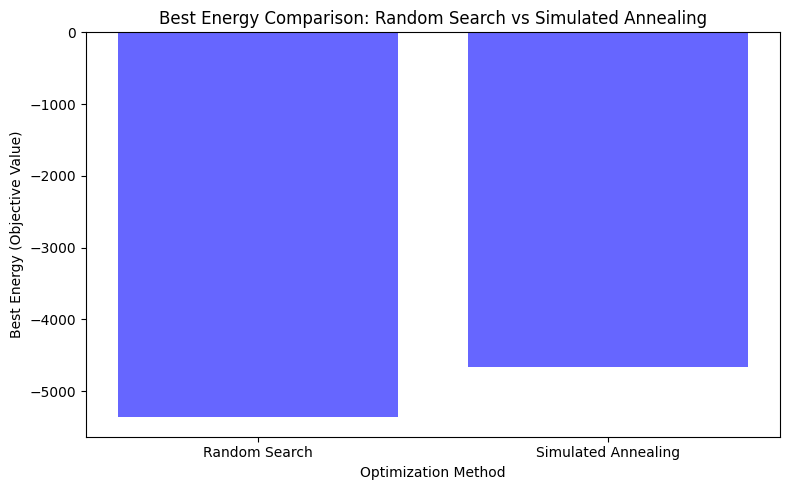

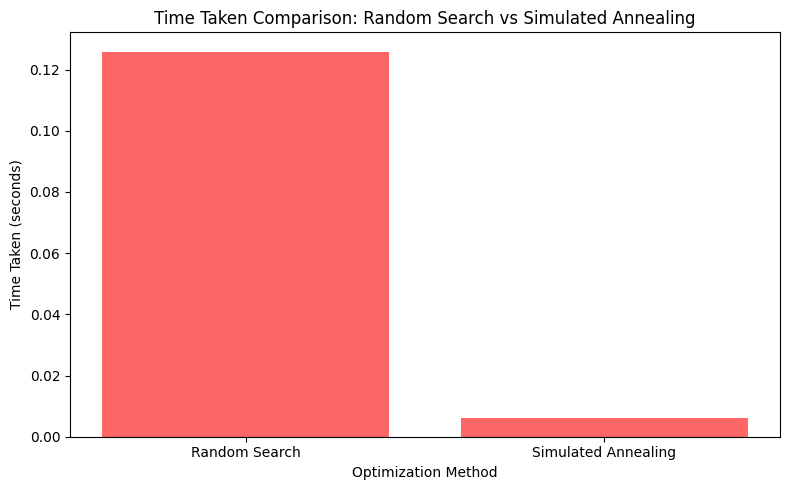

In [ ]:
import matplotlib.pyplot as plt

# Example data (replace these with your actual results)
methods = ['Random Search', 'Simulated Annealing']
best_values = [best_random_value, best_sa_value]  # Replace with actual best energy values
times = [random_search_time, simulated_annealing_time]  # Replace with actual time taken values

# First Graph: Best Energy (Objective Value) Comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, best_values, color='blue', alpha=0.6)
plt.title('Best Energy Comparison: Random Search vs Simulated Annealing')
plt.xlabel('Optimization Method')
plt.ylabel('Best Energy (Objective Value)')
plt.tight_layout()
plt.show()

# Second Graph: Time Taken Comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, times, color='red', alpha=0.6)
plt.title('Time Taken Comparison: Random Search vs Simulated Annealing')
plt.xlabel('Optimization Method')
plt.ylabel('Time Taken (seconds)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import neal



# Geodock-like Monte Carlo Search (optimized)

In [ ]:
def geodock_monte_carlo_search(hubo, num_discrete_angles=8, A_const=100, num_iterations=100):
    """
    Perform a Monte Carlo-based search for the best solution in the molecular unfolding problem.
    Optimized random search using better sampling strategies.

    Parameters:
        hubo (dict): HUBO dictionary.
        num_discrete_angles (int): Number of discrete angle choices per torsional bond.
        A_const (float): Hard constraint weight.
        num_iterations (int): Number of random solutions to generate.

    Returns:
        best_solution (list): The best solution found.
        best_objective_value (float): The corresponding objective value.
        monte_carlo_time (float): The time taken for the Monte Carlo search.
    """
    best_solution = None
    best_objective_value = float('-inf')  # Assuming we're maximizing the objective value

    _, torsional_bonds, _ = extract_from_hubo(hubo, num_discrete_angles)
    num_bonds = len(torsional_bonds)

    start_time = time.time()

    # Optimized Monte Carlo: instead of random, we will select more promising configurations
    for _ in range(num_iterations):
        # Generate a random solution, but use better probabilistic sampling or systematic steps
        random_solution = []
        for _ in range(num_bonds):  # For each bond
            one_hot = [0] * num_discrete_angles
            random_choice = random.randint(0, num_discrete_angles - 1)
            one_hot[random_choice] = 1
            random_solution.extend(one_hot)

        if len(random_solution) != num_bonds * num_discrete_angles:
            continue

        objective_value = molecular_unfolding_objective(hubo, random_solution, num_discrete_angles, A_const)

        if objective_value > best_objective_value:
            best_solution = random_solution
            best_objective_value = objective_value

    monte_carlo_time = time.time() - start_time
    return best_solution, best_objective_value, monte_carlo_time

# Simulated Annealing Search (optimized, already defined in your code)

In [ ]:
def simulated_annealing_search(bqm, num_reads=10):
    """
    Perform Simulated Annealing for the best solution in the molecular unfolding problem.
    """
    sampler = neal.SimulatedAnnealingSampler()
    start_time = time.time()
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    best_sa_solution = sampleset.first.sample
    best_sa_value = sampleset.first.energy
    sa_time = time.time() - start_time
    return best_sa_solution, best_sa_value, sa_time


# Random Search (already defined in your code)

In [ ]:
def random_search(hubo, num_discrete_angles=8, A_const=100, num_iterations=100):
    """
    Perform random search to find the best solution for the molecular unfolding problem.
    """
    best_solution = None
    best_objective_value = float('-inf')

    _, torsional_bonds, _ = extract_from_hubo(hubo, num_discrete_angles)
    num_bonds = len(torsional_bonds)

    start_time = time.time()

    for _ in range(num_iterations):
        random_solution = []
        for _ in range(num_bonds):  # For each bond
            one_hot = [0] * num_discrete_angles
            random_choice = random.randint(0, num_discrete_angles - 1)
            one_hot[random_choice] = 1
            random_solution.extend(one_hot)

        if len(random_solution) != num_bonds * num_discrete_angles:
            raise ValueError(f"Random solution size does not match expected size: {num_bonds * num_discrete_angles}")

        objective_value = molecular_unfolding_objective(hubo, random_solution, num_discrete_angles, A_const)

        if objective_value > best_objective_value:
            best_solution = random_solution
            best_objective_value = objective_value

    random_time = time.time() - start_time
    return best_solution, best_objective_value, random_time

# Applying the searching algorithms on the HUBO

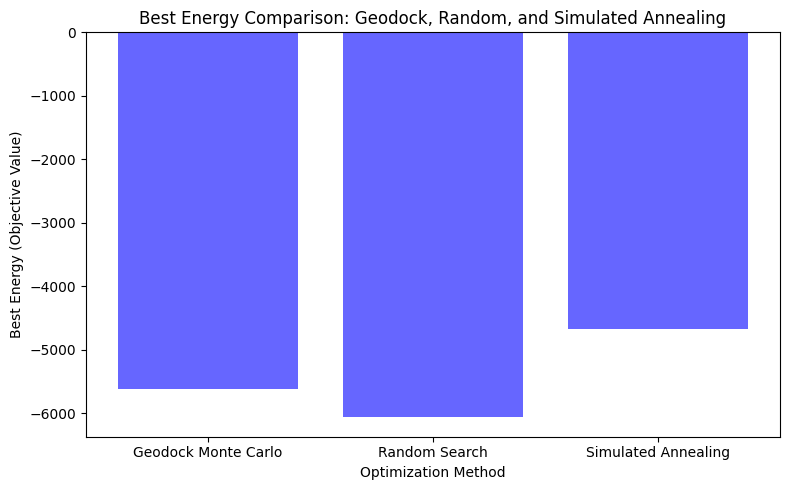

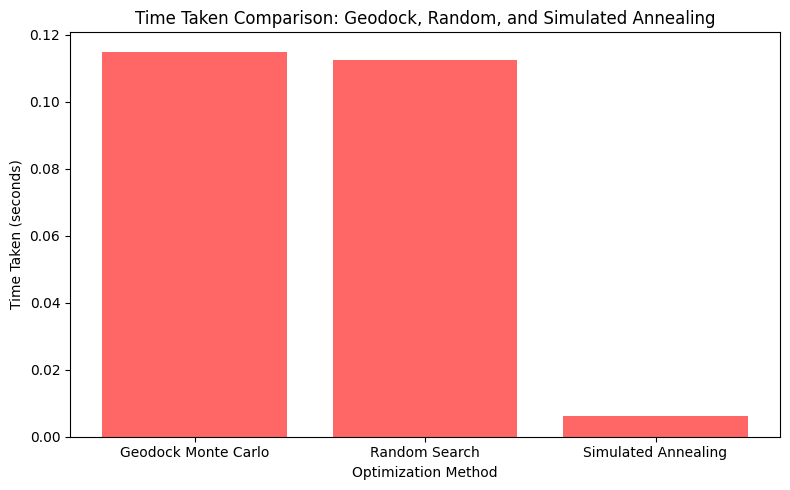

In [ ]:

example_hubo = HUBO  # Define your HUBO dictionary here

# Run Geodock Monte Carlo Search
best_geodock_monte_carlo_solution, best_geodock_monte_carlo_value, geodock_monte_carlo_time = geodock_monte_carlo_search(example_hubo, num_discrete_angles=8, num_iterations=100)

# Run Random Search (as before)
best_random_solution, best_random_value, random_time = random_search(example_hubo, num_iterations=100)

# Run Simulated Annealing (as before)
best_sa_solution, best_sa_value, sa_time = simulated_annealing_search(bqm, num_reads=10)

# Data for comparison
methods = ['Geodock Monte Carlo', 'Random Search', 'Simulated Annealing']
best_values = [best_geodock_monte_carlo_value, best_random_value, best_sa_value]
times = [geodock_monte_carlo_time, random_time, sa_time]

# Plotting Best Energy Comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, best_values, color='blue', alpha=0.6)
plt.title('Best Energy Comparison: Geodock, Random, and Simulated Annealing')
plt.xlabel('Optimization Method')
plt.ylabel('Best Energy (Objective Value)')
plt.tight_layout()
plt.show()

# Plotting Time Comparison
plt.figure(figsize=(8, 5))
plt.bar(methods, times, color='red', alpha=0.6)
plt.title('Time Taken Comparison: Geodock, Random, and Simulated Annealing')
plt.xlabel('Optimization Method')
plt.ylabel('Time Taken (seconds)')
plt.tight_layout()
plt.show()
